In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
import os
from scipy.interpolate import interp1d

In [2]:
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['figure.figsize'] = (10, 8)


In [3]:
N = 2 ** 23  # Number of sample points (power of 2 for FFT efficiency)
#resonator_frequency = 7.252534 * 10 ** 9  # Resonator frequency (Hz)
resonator_frequency = 6.9 * 10 ** 9  # Resonator frequency (Hz)


In [4]:
def s11_for_both_states_mocked(f_resonator: float, target_pulse_frequencies: np.ndarray = None, plot: bool = False):
    # --- S_11 Mock Function for a reflection resonator---
    def get_s11(probe_freq, res_freq_shifted, hwhm_freq, s11_on_res_signed):
        delta_f = probe_freq - res_freq_shifted

        kappa_hwhm_diff_term = s11_on_res_signed * kappa_hwhm

        numerator = 1j * delta_f - kappa_hwhm_diff_term
        denominator = kappa_hwhm + 1j * delta_f
        return numerator / denominator

    # --- Parameters ---
    kappa_hwhm = 1000  # Linewidth (HWHM of |S11| dip)
    chi_2pi = (156 * 10 ** 3) / 2  # Dispersive shift chi/2π
    s11_on_res = 0.1  # |S_11| on resonance

    # Shifted resonant frequencies for qubit states
    f_resonator_0_shifted = f_resonator + chi_2pi
    f_resonator_1_shifted = f_resonator - chi_2pi

    # Sweep omega_RF around omega_r
    omega_rf_sweep = target_pulse_frequencies * 2 * np.pi if target_pulse_frequencies is not None else np.linspace(
        f_resonator * 0.999, f_resonator * 1.001, N)

    s11_0 = get_s11(omega_rf_sweep, f_resonator_0_shifted, kappa_hwhm, s11_on_res)
    s11_1 = get_s11(omega_rf_sweep, f_resonator_1_shifted, kappa_hwhm, s11_on_res)

    s11_phase_0_unwrapped = np.unwrap(np.angle(s11_0))
    s11_phase_1_unwrapped = np.unwrap(np.angle(s11_1))

    # --- Plotting ---
    if plot:
        s11_plot_edges = np.array((-chi_2pi * 3, chi_2pi * 3)) + f_resonator

        fig, ax = plt.subplots(4, 1)

        # Plot 1: Real Part
        ax[0].plot(omega_rf_sweep, np.abs(s11_0), label='|0>')
        ax[0].plot(omega_rf_sweep, np.abs(s11_1), label='|1>')

        ax[0].set_ylabel('$|S_{11}|$')
        ax[0].set_xlim(s11_plot_edges)

        ax[0].grid(True)
        ax[0].legend()

        # Plot 1: Imaginary Part
        ax[1].plot(omega_rf_sweep, np.imag(s11_0))
        ax[1].plot(omega_rf_sweep, np.imag(s11_1))

        ax[1].set_ylabel('$Im[S_{11}]$')
        ax[1].set_xlim(s11_plot_edges)

        ax[1].grid(True)

        # Plot 2: Real Part
        ax[2].plot(omega_rf_sweep, np.real(s11_0))
        ax[2].plot(omega_rf_sweep, np.real(s11_1))

        ax[2].set_ylabel('$Re[S_{11}]$')
        ax[2].set_xlim(s11_plot_edges)

        ax[2].grid(True)

        # Plot 3: Argument
        ax[3].plot(omega_rf_sweep, s11_phase_0_unwrapped)
        ax[3].plot(omega_rf_sweep, s11_phase_1_unwrapped)

        ax[3].set_ylabel('$\\theta$ (rad)')
        ax[3].set_xlabel('Frequency, $\\omega_{RF} - \\omega_r$')
        ax[3].set_xlim(s11_plot_edges)
        ax[3].grid(True)

        plt.tight_layout()

        plt.show()

    return omega_rf_sweep / (2 * np.pi), s11_0, s11_1

In [5]:
def s11_s21_from_s2p_file(simulation_results_filename: str,
                          target_pulse_frequencies: np.ndarray = None,
                          plot: bool = False):
    current_path = os.path.abspath("")
    data_dir_path = os.path.join(current_path, "data")
    file_path = os.path.join(data_dir_path, simulation_results_filename)

    try:
        network = rf.Network(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None, None, None

    s11_original = network.s[:, 0, 0]
    s21_original = network.s[:, 1, 0]
    frequencies_original = network.f

    s11_processed = s11_original
    s21_processed = s21_original
    frequencies_processed = frequencies_original

    min_orig_freq = np.min(frequencies_original)
    max_orig_freq = np.max(frequencies_original)

    if target_pulse_frequencies is not None:
        print(f"Interpolating S-parameters to {len(target_pulse_frequencies)} target frequencies.")

        min_target_freq = np.min(target_pulse_frequencies)
        max_target_freq = np.max(target_pulse_frequencies)

        if min_target_freq < min_orig_freq or max_target_freq > max_orig_freq:
            print(f"Warning: Target frequencies [{min_target_freq:.2e} Hz, {max_target_freq:.2e} Hz] "
                  f"are outside the original S-parameter frequency range "
                  f"[{min_orig_freq:.2e} Hz, {max_orig_freq:.2e} Hz]. "
                  "Interpolation might extrapolate.")

        # Interpolate S11
        interp_s11_real = interp1d(frequencies_original, np.real(s11_original), kind='cubic',
                                   bounds_error=False,
                                   fill_value=0)  # Can also use fill_value="extrapolate" for some scipy versions
        interp_s11_imag = interp1d(frequencies_original, np.imag(s11_original), kind='cubic',
                                   bounds_error=False, fill_value=0)
        s11_interpolated_real = interp_s11_real(target_pulse_frequencies)
        s11_interpolated_imag = interp_s11_imag(target_pulse_frequencies)
        s11_processed = s11_interpolated_real + 1j * s11_interpolated_imag

        # Interpolate S21
        interp_s21_real = interp1d(frequencies_original, np.real(s21_original), kind='cubic',
                                   bounds_error=False, fill_value=0)
        interp_s21_imag = interp1d(frequencies_original, np.imag(s21_original), kind='cubic',
                                   bounds_error=False, fill_value=0)
        s21_interpolated_real = interp_s21_real(target_pulse_frequencies)
        s21_interpolated_imag = interp_s21_imag(target_pulse_frequencies)
        s21_processed = s21_interpolated_real + 1j * s21_interpolated_imag

        frequencies_processed = target_pulse_frequencies
        print("Interpolation complete.")

    plot_edges = (min_orig_freq*0.99, max_orig_freq*1.01)
    if plot:
        # Create a new figure for these plots
        _, ax = plt.subplots(3, 1, sharex=True)

        # Plot 1: Magnitude
        ax[0].plot(frequencies_processed, np.abs(s11_processed), label='$|S_{11}|$')
        ax[0].plot(frequencies_processed, np.abs(s21_processed), label='$|S_{21}|$')
        ax[0].set_ylabel('$|S_{xx}|$')
        ax[0].set_xlim(plot_edges)
        ax[0].grid(True)
        ax[0].legend()
        ax[0].set_title(f'S-Parameters from {simulation_results_filename}')

        # Plot 2: Imaginary Part
        ax[1].plot(frequencies_processed, np.imag(s11_processed), label='$Im(S_{11})$')
        ax[1].plot(frequencies_processed, np.imag(s21_processed), label='$Im(S_{21})$')
        ax[1].set_ylabel('$Im(S_{xx})$')
        ax[1].set_xlim(plot_edges)
        ax[1].grid(True)
        ax[1].legend()

        # Plot 3: Real Part
        ax[2].plot(frequencies_processed, np.real(s11_processed), label='$Re(S_{11})$')
        ax[2].plot(frequencies_processed, np.real(s21_processed), label='$Re(S_{21})$')
        ax[2].set_ylabel('$Re(S_{xx})$')  # Corrected label
        ax[2].set_xlabel('Frequency (Hz)')  # Add x-label to the last plot
        ax[2].set_xlim(plot_edges)
        ax[2].grid(True)
        ax[2].legend()

        plt.tight_layout()
        plt.show()

    return frequencies_processed, s11_processed, s21_processed

In [6]:
def create_rectangle_pulse(f_resonator: float, samples_number: int, plot: bool = False, ):
    # --- Time Domain Parameters ---
    total_signal_time = 4 * 10 ** (-4)  # Total time duration of the signal (seconds)
    dt = total_signal_time / samples_number  # Time step (sampling interval)
    times = np.linspace(0, total_signal_time, samples_number, endpoint=False)  # Time vector

    # --- Rectangular Pulse Parameters ---
    pulse_width = 3.5 * 10 ** (-6)  # (seconds)
    pulse_amplitude = 1.0  # a.u.
    pulse_start_time = (total_signal_time - pulse_width) / 2  # (seconds)
    pulse_frequency = f_resonator

    # --- Create the Rectangular Pulse in Time Domain ---
    pulse_signal = np.zeros(samples_number)
    pulse_signal[(times >= pulse_start_time) & (times < pulse_start_time + pulse_width)] = pulse_amplitude
    pulse_signal = pulse_signal * np.exp(1j * pulse_frequency * 2 * np.pi * times)  # Phase = 0

    # --- To Frequency Domain ---
    yf = np.fft.fft(pulse_signal)
    xf = np.fft.fftfreq(samples_number, dt)

    pulse_f_signal = np.fft.fftshift(yf)
    pulse_f_frequencies = np.fft.fftshift(xf)


    # --- Plotting ---
    pulse_f_plot_edges = (pulse_frequency * 0.99, pulse_frequency * 1.01)
    pulse_t_plot_edges = (pulse_start_time * 0.99, pulse_start_time * 1.01 + pulse_width)
    if plot:
        plt.figure(figsize=(12, 8))

        fig, ax = plt.subplots(2, 1)

        # Plot 1: Time Domain
        ax[0].plot(times, np.real(pulse_signal))
        ax[0].set_title('Time Domain')
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('Amplitude')
        ax[0].set_xlim(pulse_t_plot_edges)
        ax[0].grid(True)
        ax[0].tick_params(axis='x', labelrotation=45)
        # Plot 2: Frequency Domain

        ax[1].plot(pulse_f_frequencies, np.abs(pulse_f_signal))
        ax[1].set_title('Magnitude Spectrum')
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Magnitude')
        ax[1].set_xlim(pulse_f_plot_edges)
        ax[1].grid(True)

        plt.tight_layout()
        plt.show()

    return pulse_f_frequencies, pulse_f_signal, times, pulse_t_plot_edges

In [7]:
def readout_signal_after_interaction_with_resonator(s: np.ndarray, pulse: np.ndarray, frequencies: np.ndarray,
                                                    plot: bool = False):
    result = s * pulse
    if plot:
        max_amplitude_frequency = frequencies[np.argmax(result)]
        plt.plot(frequencies, np.abs(result))
        plt.title('Read out signal after interaction with resonator')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.xlim((max_amplitude_frequency * 0.99, max_amplitude_frequency * 1.01))
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    return result

<Figure size 1200x800 with 0 Axes>

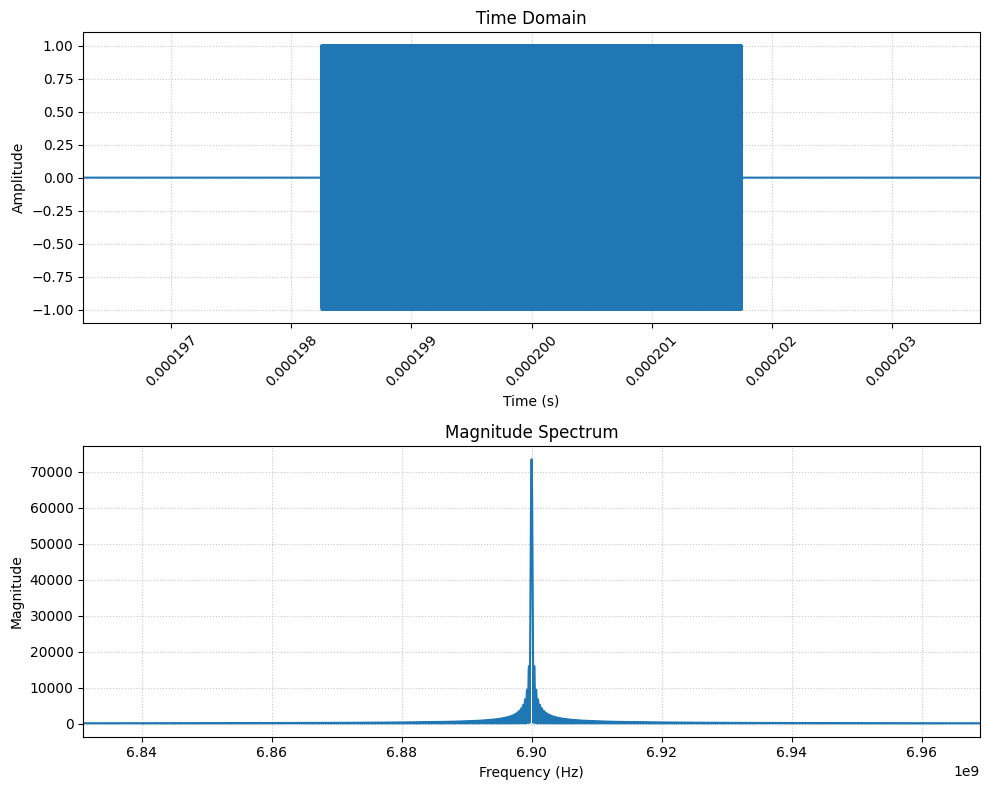

In [8]:
frequencies_pulse, pulse, times_pulse, pulse_t_plot_edges = create_rectangle_pulse(
    f_resonator=resonator_frequency,
    samples_number=N,
    plot=True)

Interpolating S-parameters to 8388608 target frequencies.
Interpolation complete.


/var/folders/4v/sw011n6n73n99lwpjk6j8klm0000gp/T/ipykernel_18854/1676063452.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/user/PycharmProjects/readout_simulation/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


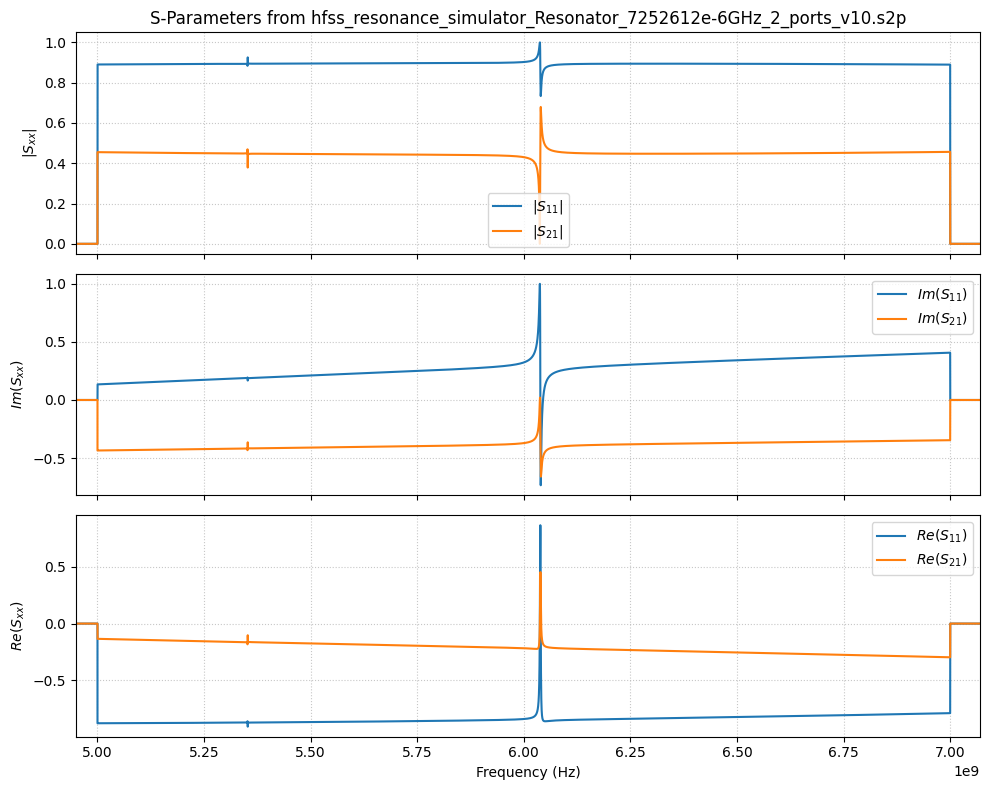

In [9]:
_, s11_simulation, s21_simulation = s11_s21_from_s2p_file(
    simulation_results_filename='hfss_resonance_simulator_Resonator_7252612e-6GHz_2_ports_v10.s2p',
    target_pulse_frequencies=frequencies_pulse,
    plot=True,
)

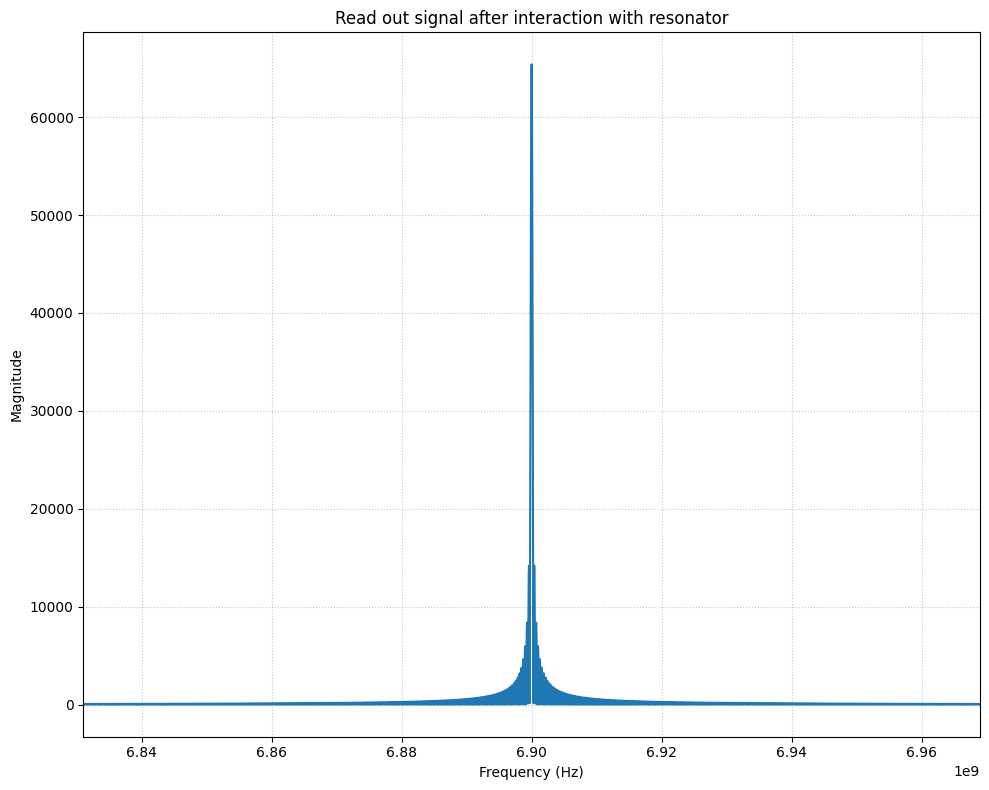

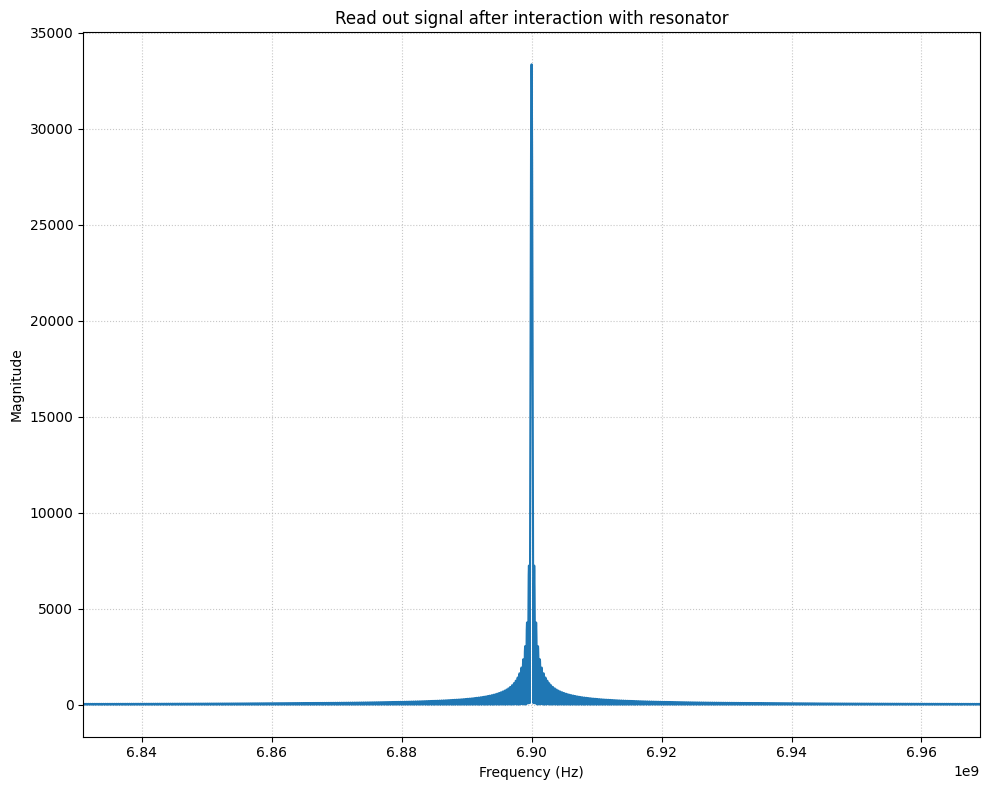

In [10]:
reflected_signal = readout_signal_after_interaction_with_resonator(s=s11_simulation,
                                                                   pulse=pulse,
                                                                   frequencies=frequencies_pulse,
                                                                   plot=True)
transited_signal = readout_signal_after_interaction_with_resonator(s=s21_simulation,
                                                                   pulse=pulse,
                                                                   frequencies=frequencies_pulse,
                                                                   plot=True)

/Users/user/PycharmProjects/readout_simulation/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/user/PycharmProjects/readout_simulation/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 1200x800 with 0 Axes>

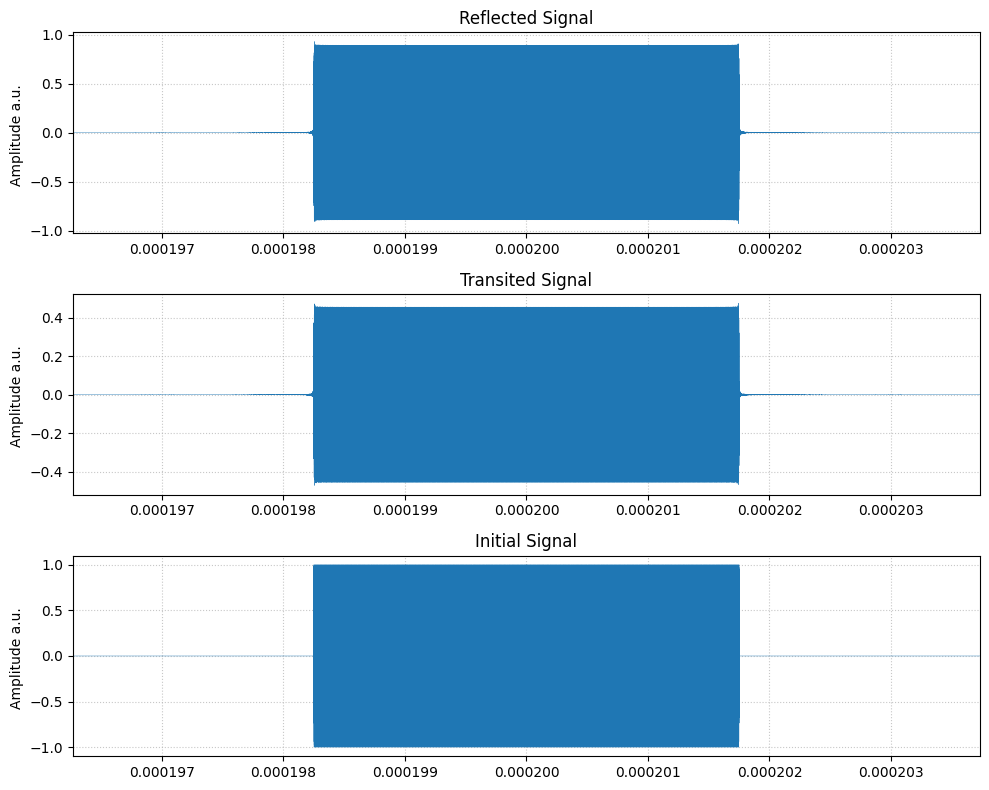

In [11]:
reflected_t_signal = np.fft.ifft(np.fft.ifftshift(reflected_signal))
transited_t_signal = np.fft.ifft(np.fft.ifftshift(transited_signal))
initial_t_pulse_signal = np.fft.ifft(np.fft.ifftshift(pulse))

plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(3, 1)

ax[0].plot(times_pulse, reflected_t_signal, lw=0.3)
ax[0].set_title('Reflected Signal')
ax[0].set_ylabel('Amplitude a.u. ')
ax[0].set_xlim(pulse_t_plot_edges)
ax[0].grid(True)

ax[1].plot(times_pulse, transited_t_signal, lw=0.3)
ax[1].set_title('Transited Signal')
ax[1].set_ylabel('Amplitude a.u. ')
ax[1].set_xlim(pulse_t_plot_edges)
ax[1].grid(True)

ax[2].plot(times_pulse, initial_t_pulse_signal, lw=0.3)
ax[2].set_title('Initial Signal')
ax[2].set_ylabel('Amplitude a.u. ')
ax[2].set_xlim(pulse_t_plot_edges)
ax[2].grid(True)

plt.tight_layout()
plt.show()